# Model Simulation and Inference

In this notebook, we provide simple annotated examples of running simulations and inferring parameters using the networked-endorsement model described in the paper "Emergence of Hierarchy in Networked Endorsement Dynamics" by [Mari Kawakatsu](https://scholar.princeton.edu/ctarnita/people/mari-kawakatsu), [Phil Chodrow](https://www.philchodrow.com/), [Nicole Eikmeier](https://eikmeier.sites.grinnell.edu/), and [Dan Larremore](https://larremorelab.github.io/). 

In [1]:
import numpy as np

from py.model import *
from py.scores import *
from py.utils import *
# from numba import jit

from SpringRank import SpringRank
from matplotlib import pyplot as plt

# Simulation

First, we'll illustrate how to generate synthetic trajectories from given model parameters. We'll first set up our parameters. 

In [2]:
n_rounds = 200                            # number of time periods 
n = 20                                    # number of agents

A = np.random.randint(10, size = (n,n))   # random initial condition, with normalization
A0 = A/A.sum()*n

beta = np.array([2.9, -1.5])              # preference parameters (for linear and quadratic terms)
lam = .9                                  # timescale parameter

We next instantiate a `model` object, which includes both *scores* and *feature maps*. We use the SpringRank score with linear and quadratic feature maps described in the main text. Note that the implementation of SpringRank from the SpringRank package operates on the transpose of the endorsement matrix, so we in turn need to transpose `A` in order to get correct results. 

The score function should map an $n\times n$ matrix to a $n$-vector, while each feature map should map an $n$-vector to an $n\times n$ matrix. The first feature will be premultiplied by `beta[0]`, the second by `beta[1]`, etc. 

In [3]:
L = model()

L.set_score(
    score_function = lambda A: SpringRank.SpringRank(A.T)
)

def quadratic_feature(s):
    S = np.tile(s, (n,1))
    F = (S - S.T)**2
    return(F)

L.set_features([
    lambda s: np.tile(s, (n,1)),    # linear feature
    quadratic_feature               # quadratic feature
])

We are now prepared to simulate our model with parameters `beta` and `lam` and initial condition `A0`. The output of the call to `simulate` is a 3-dimensional array `T` in which `T[i]` gives the *new endorsements* at timestep `i`. 

In [4]:
# generate some fake data

T = L.simulate(beta = beta, 
               lam = lam, 
               A0 = A0,
               n_rounds = n_rounds,
               m_updates = 1)

In order to visualize the results, we need the model to explicitly represent the state matrix `A` at each timestep, as well as the corresponding scores, features, and rate matrix. 

In [5]:
# with known parameters, infer the rate matrix from the fake data

L.set_data(T, T[0]) # set the data and specify initial condition
L.compute_state_matrix(lam = lam)
L.compute_score()
L.compute_features()
L.compute_rate_matrix(beta = beta)

GAMMA = L.get_rates().mean(axis = 1)

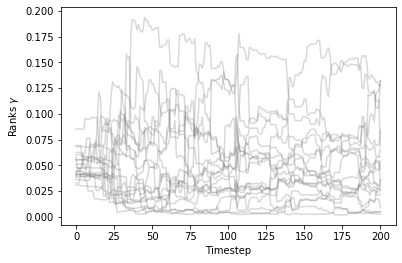

In [6]:
p = plt.plot(GAMMA, color = 'grey', alpha = .3)
plt.xlabel('Timestep')
plt.ylabel(r'Ranks $\gamma$');

# Parameter Inference

In the inferential setting, we imagine that the increments `T` are presented to us as *data*. Supposing that we know the score function and feature maps, we would like to learn the parameters `beta` and `lambda`. 

Because we already called `L.set_data()` above, all we need to do is call `L.ML()` to perform maximum-likelihood. There are several control parameters. 

- `lam0` controls the initial guess for `lambda`
- `alpha0` controls the initial step size used by the bespoke hill-climbing algorithm used to optimize `lambda`. 
- `tol` determines the tolerance of convergence for the algorithm. 
- `step_cap` is the largest step-size allowable in running search for `lambda`, and can be used to prevent large steps from causing `lambda > 1` or `lambda < 0`. 

There are no control parameters for the optimization over `beta`, because for fixed `lambda` this problem is convex and can easily be handled by built-in solvers. 

In [7]:
res = L.ML(lam0 = .8, 
           alpha0 = 10**(-2), 
           tol = 10**(-1), 
           step_cap = .05,
           print_updates = True)

computing memory hyperparameter lambda
Lambda = 0.8500000000000001, LL = 504.0013083994939
Lambda = 0.9000000000000001, LL = 492.9776179360228
Lambda = 0.8998046875000001, LL = 492.9722917063028
computing parameter vector beta


We can also estimate the Hessian matrix of the log-likelihood function, and use this to obtain estimates of the standard errors of the estimates. Note that this call can be slow depending on the computational effort required by the score function. 

In [8]:
H = L.estimate_hessian(res['lam'], res['beta']) 
se = np.sqrt(np.diag(np.linalg.inv(-H)))

In [9]:
LL_string = 'Log-Likelihood = ' + str(np.around(res['LL'], 0))

lam_hat = f"{res['lam']:.2f}" + ' (' + f"{se[0]:.2f}" + ')'
b1_hat = f"{res['beta'][0]:.2f}" + ' (' + f"{se[1]:.2f}" + ')'
b2_hat = f"{res['beta'][1]:.2f}" + ' (' + f"{se[2]:.2f}" + ')'

LL = f"{res['LL']:.0f}"

print("The true parameters were lambda = " + str(lam) + ", beta_1 = " + str(beta[0]) + ", and beta_2 = " + str(beta[1]) + ".")
print("The estimates are lambda = " + lam_hat + ", beta_1 = " + b1_hat + ", and beta_2 = " + b2_hat + " with " + LL_string + ".")

The true parameters were lambda = 0.9, beta_1 = 2.9, and beta_2 = -1.5.
The estimates are lambda = 0.90 (0.01), beta_1 = 2.68 (0.31), and beta_2 = -1.34 (0.19) with Log-Likelihood = -493.0.


As we would expect, the estimated parameters are close to the true parameters, and the true parameters would fall in 2-standard-error confidence intervals of the estimates. 